Testing to read the zarr data produced by Aasmund

In [1]:
import xarray as xr
import numpy as np
#import requests
#from bs4 import BeautifulSoup
import cartopy.crs as ccrs
import pyproj
import pyresample
import datetime
#from datetime import datetime
#import dask.array as da
#from dask.distributed import Client
#from dask_jobqueue import SLURMCluster
#from numcodecs.blosc import Blosc


In [2]:
carra_analysis = xr.open_zarr(f"/scratch/fab0/Projects/cerise/carra_snow_data/ana_v2.zarr")

In [4]:
##carra_analysis.to_netcdf("analysis_zarr_test.nc")

In [5]:
carra_analysis.projection

'+R=6371000 +lat_0=80 +lat_1=80 +lat_2=80 +lon_0=-34 +no_defs +proj=lcc +type=crs +units=m +x_0=0 +y_0=0'

## Reading the ims resampled data

In [6]:
ims_in_carra1=xr.open_zarr("/ec/res4/scratch/nhd/CERISE/IMS_snow_cover/ims.zarr")

In [7]:
#ims_in_carra1.variables

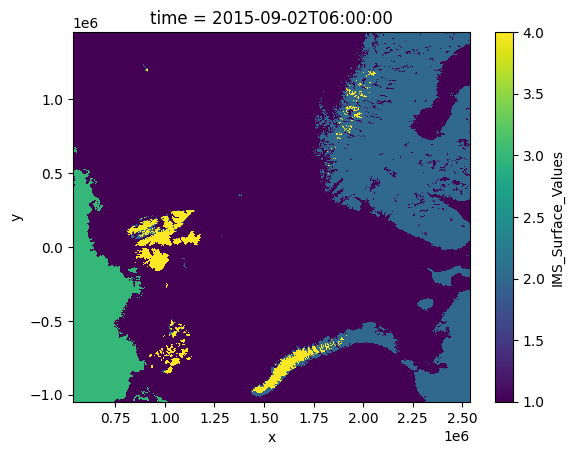

In [8]:
ims_in_carra1["IMS_Surface_Values"][0,:,:].plot()

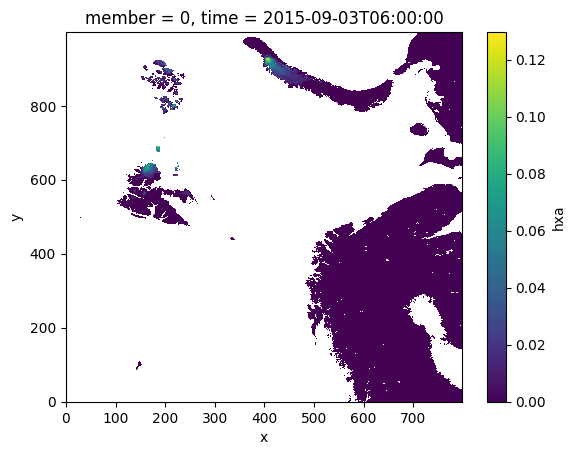

In [9]:
carra_analysis["hxa"][:,:,1,0].plot()

In [10]:
#ims_in_carra1.time[0]

In [11]:
#type(ims_in_carra1)

In [12]:
#ims_in_carra1.time

In [13]:
select_ims = ims_in_carra1.sel(time="2016-05-10")

In [14]:
select_carra1 = carra_analysis.sel(time="2016-05-10")

In [15]:
#select_carra1.to_netcdf("carra1_2016-05-10.nc")

In [16]:
#select_ims.to_netcdf("ims_2016-05-10.nc")

In [17]:
carra_subset = select_carra1.sel(member=0,patch=0,stid=1003.) #wth is patch and stid??

In [18]:
#carra_subset["hxa"]

In [20]:
# create a binary variable called bin_snow
carra_subset["bin_snow"]  = xr.where(carra_subset["hxa"] > 0.01, 1, 0)

In [21]:
select_ims["bin_snow"]  = xr.where(select_ims["IMS_Surface_Values"] == 0, 1, 0)

In [22]:
#select_ims.to_netcdf("ims_2016-05-10.nc")

In [23]:
#carra_subset.to_netcdf("carra1_2016-05-10.nc")

In [25]:
carra_subset.projection

'+R=6371000 +lat_0=80 +lat_1=80 +lat_2=80 +lon_0=-34 +no_defs +proj=lcc +type=crs +units=m +x_0=0 +y_0=0'

In [ ]:
# Update the projection part
carra_subset.attrs["grid_mapping"] = "lambert_conformal_conic"
carra_subset.attrs["proj4"] = carra_subset.projection
carra_subset.attrs["nx"] = carra_subset.dims["x"]
carra_subset.attrs["ny"] = carra_subset.dims["y"]
carra_subset.to_netcdf("carra1_2016-05-10.nc")


/etc/ecmwf/ssd/ssd1/tmpdirs/nhd.2738326.20250129_122253.074/ipykernel_2775412/2101526120.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  carra_subset.attrs["nx"] = carra_subset.dims["x"]
/etc/ecmwf/ssd/ssd1/tmpdirs/nhd.2738326.20250129_122253.074/ipykernel_2775412/2101526120.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  carra_subset.attrs["ny"] = carra_subset.dims["y"]


In [27]:
select_ims.attrs

{}

In [28]:
def seconds_to_unix_time(seconds_since_1978):
    # Add seconds since 1978-01-01 00:00:00 to the base datetime
    base_datetime = datetime.datetime(1978, 1, 1, 0, 0, 0)
    target_datetime = base_datetime + datetime.timedelta(seconds=seconds_since_1978)

    # Convert the datetime object to Unix timestamp
    unix_timestamp = target_datetime.timestamp()

    return unix_timestamp



In [29]:
carra_subset.time.values

array(['2016-05-10T06:00:00.000000000'], dtype='datetime64[ns]')

In [30]:
times = carra_subset.time.values
reference_date = np.datetime64('1978-01-01T00:00:00.000000000')

seconds_since_1978=[]
for t in times:
    seconds_since_1978.append((t - reference_date)/np.timedelta64(1, 's'))
std_unix_time=[seconds_to_unix_time(ts) for ts in seconds_since_1978]

In [32]:
std_unix_time

[1462860000.0]

In [33]:
carra_subset["bin_snow"]

<xarray.DataArray 'bin_snow' (y: 1000, x: 800, time: 1)> Size: 6MB
dask.array<where, shape=(1000, 800, 1), dtype=int64, chunksize=(100, 100, 1), chunktype=numpy.ndarray>
Coordinates:
    member   int16 2B 0
    patch    int16 2B 0
    stid     float64 8B 1.003e+03
  * time     (time) datetime64[ns] 8B 2016-05-10T06:00:00
  * x        (x) float32 3kB 0.0 1.0 2.0 3.0 4.0 ... 796.0 797.0 798.0 799.0
  * y        (y) float32 4kB 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0

In [35]:
#Create new output file with the variables I need
bin_data=carra_subset["bin_snow"].values
ds_carra = xr.Dataset(
    {
        "bin_snow": (["y","x","time"], bin_data),
    },
    coords={
        "time": std_unix_time, #seconds_since_1978,
        "y": carra_subset["y"].values,
        "x": carra_subset['x'].values,
    },
)





In [44]:
carra_subset.projection

'+R=6371000 +lat_0=80 +lat_1=80 +lat_2=80 +lon_0=-34 +no_defs +proj=lcc +type=crs +units=m +x_0=0 +y_0=0'

In [47]:
ds_carra.time.attrs["units"] = "seconds since 1970-01-01 00:00:00"
ds_carra.time.attrs["long_name"] = "reference time of product"
#ds_carra.lon.attrs["units"] = "degrees_east"
#ds_carra.lat.attrs["units"] = "degrees_north"
ds_carra["bin_snow"].attrs["units"] = "None"
ds_carra["bin_snow"].attrs["units"] = "None"
ds_carra["bin_snow"].attrs["coordinates"] = "y x"
ds_carra["bin_snow"].attrs["grid_mapping"] = "lambert_conformal_conic"


ds_carra.attrs["grid_mapping"] = "lambert_conformal_conic"
ds_carra.attrs["proj4"] = carra_subset.projection
ds_carra.attrs["nx"] = carra_subset.dims["x"]
ds_carra.attrs["ny"] = carra_subset.dims["y"]
ds_carra.x.attrs["long_name"] = "x coordinate of projection"
ds_carra.x.attrs["standard_name"] = "projection_x_coordinate"

ds_carra.y.attrs["long_name"] = "y coordinate of projection"
ds_carra.y.attrs["standard_name"] = "projection_y_coordinate"


ds_carra.to_netcdf("carra1_2016-05-10.nc")
from netCDF4 import Dataset

fid = Dataset("carra1_2016-05-10.nc", 'a', format='NETCDF4')
#proj_var = fid.createVariable('projection_regular_ll', 'S1', ())
proj_var = fid.createVariable('lambert_conformal_conic', 'i4', ())
proj_var.grid_mapping_name = "lambert_conformal_conic"
proj_var.false_northing = 0.0
proj_var.earth_shape = "spherical"
proj_var.standard_parallel=80
proj_var.longitude_of_central_meridian = -34
proj_var.latitude_of_projection_origin = 80



#grid_mapping:standard_parallel = 25. ;
#        grid_mapping:longitude_of_central_meridian = -95. ;
#        grid_mapping:latitude_of_projection_origin = 25. ;
#        grid_mapping:false_easting = 0 ;
#        grid_mapping:false_northing = 0 ;
#        grid_mapping:GRIB_earth_shape = "spherical" ;
#        grid_mapping:GRIB_earth_shape_code = 0 
#proj_var.proj4 = "+proj=laea +ellps=WGS84 +lat_0=90 +lon_0=0"
#proj_var.proj4 = "+proj=longlat +datum=WGS84"
proj_var.proj4=carra_subset.projection
fid.close()





#ds_carra.attrs["grid_mapping"] = "latitude_longitude"
#ds_carra.attrs["proj4"] = "+proj=longlat +datum=WGS84"
#ds_carra.attrs["proj"] = ds_harm[var_out].attrs["GRIB_gridType"]
#ds_carra.attrs["nx"] = ds_harm[var_out].attrs["GRIB_Nx"]
#ds_carra.attrs["ny"] = ds_harm[var_out].attrs["GRIB_Ny"]
#ds_carra.attrs["dx"] = ds_harm[var_out].attrs["GRIB_iDirectionIncrementInDegrees"]
#ds_carra.attrs["dy"] = ds_harm[var_out].attrs["GRIB_jDirectionIncrementInDegrees"]
#ds_carra.attrs["SW_lat"] = ds_harm[var_out].attrs["GRIB_latitudeOfFirstGridPointInDegrees"]
#ds_carra.attrs["NE_lat"] = ds_harm[var_out].attrs["GRIB_latitudeOfLastGridPointInDegrees"]
#ds_carra.attrs["SW_lon"] = ds_harm[var_out].attrs["GRIB_longitudeOfFirstGridPointInDegrees"]
#ds_carra.attrs["NE_lon"] = ds_harm[var_out].attrs["GRIB_longitudeOfLastGridPointInDegrees"]



/etc/ecmwf/ssd/ssd1/tmpdirs/nhd.2738326.20250129_122253.074/ipykernel_2775412/3809907324.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds_carra.attrs["nx"] = carra_subset.dims["x"]
/etc/ecmwf/ssd/ssd1/tmpdirs/nhd.2738326.20250129_122253.074/ipykernel_2775412/3809907324.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds_carra.attrs["ny"] = carra_subset.dims["y"]


In [40]:
# Update the projection part
select_ims.attrs["grid_mapping"] = select_ims.attrs.get("grid_mapping")
select_ims.attrs["proj4"] = carra_subset.projection
select_ims.attrs["nx"] = select_ims.dims["x"]
select_ims.attrs["ny"] = select_ims.dims["y"]
select_ims.to_netcdf("ims_2016-05-10.nc")

/etc/ecmwf/ssd/ssd1/tmpdirs/nhd.1893342.20250129_101352.757/ipykernel_167387/3997540304.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  select_ims.attrs["nx"] = select_ims.dims["x"]
/etc/ecmwf/ssd/ssd1/tmpdirs/nhd.1893342.20250129_101352.757/ipykernel_167387/3997540304.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  select_ims.attrs["ny"] = select_ims.dims["y"]


In [41]:
carra_subset

<xarray.Dataset> Size: 29MB
Dimensions:    (time: 1, y: 1000, x: 800)
Coordinates:
    member     int16 2B 0
    patch      int16 2B 0
    stid       float64 8B 1.003e+03
  * time       (time) datetime64[ns] 8B 2016-05-10T06:00:00
  * x          (x) float32 3kB 0.0 1.0 2.0 3.0 4.0 ... 796.0 797.0 798.0 799.0
  * y          (y) float32 4kB 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0
Data variables: (12/16)
    hofx       (time) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    hxa        (y, x, time) float32 3MB dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
    hxb        (y, x, time) float32 3MB dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
    lat        (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    lat_obs    float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lon        (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...         ...
    x_obs      float32 4B dask.array<chunksize=(), meta=np.ndarray>
    xpatch     (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    y_mod      (y) float32 4kB dask.array<chunksize=(100,), meta=np.ndarray>
    y_obs      float32 4B dask.array<chunksize=(), meta=np.ndarray>
    yo         (time) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    bin_snow   (y, x, time) int64 6MB dask.array<chunksize=(100, 100, 1), meta=np.ndarray>
Attributes:
    bounding_box:  [537154.7371957821, -1047009.2943193722, 2537154.737195782...
    grid_size:     [800, 1000]
    projection:    +R=6371000 +lat_0=80 +lat_1=80 +lat_2=80 +lon_0=-34 +no_de...
    grid_mapping:  lcc
    proj4:         +R=6371000 +lat_0=80 +lat_1=80 +lat_2=80 +lon_0=-34 +no_de...
    nx:            800
    ny:            1000